In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes
from PIL import Image
import os
from scipy.optimize import curve_fit
from scipy import signal
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from reproject import reproject_interp
import pandas as pd
import glob
from trilogy import trilogy
import calendar


plt.style.use('light_mode')

### Even though you are submitting these with `git` and this file tells you to rename it, and you should be pushing to a dedicated folder with your username, please also stick your name in this file here, so there's extra redundancy. 

The point of this Midterm is to 
- cover material that we haven't had a chance to put on a homework yet
- throw in a curveball that will require you to actually understand the material you learned
- generally give me a sense of where you all are at the halfway point 

# Q1. Noise, Simulations and Fourier Transforms ( 40 pts)

You should probably begin by reading this short article on how to generate noise
https://paulbourke.net/fractals/noise/

Generate the following time streams: 
- 5.5 Hz signal
- "dirty" 60 Hz signal (hint: https://ep2000.com/what-is-dirty-electricity-and-how-to-remove-it-from-your-home/?v=e75edac1b83f - how you generate the noise is up to you - you can round the value of a sine wave for instance to the nearest something)
- white noise
- Brownian noise
- 1/f noise
- sum of all the above

8 points each:
a) Plot the time streams and make the plot pretty (I'm not being as specific as before because you ought to know by now).

b) Measure the standard deviation of each noise time stream. Count and report the number of time samples above (or below) 3 sigma.

c) Fourier Transform the time streams and plot the power spectral densities

d) Do a power law fit and measure the slope of the noise components. What is alpha (1/f^alpha) for the various components? (Report an error) Show your fits. (https://scipy-cookbook.readthedocs.io/items/FittingData.html) 

e) To the total timestream: (3 + 3 + 2)
- apply a high-pass filter
- apply a low-pass filter
- plot the power spectral density

In [2]:
def gen_white_noise(nsamp):
    noise = np.random.randn(nsamp)
    return noise

def gen_colored_noise(beta, nsamp, freqs):
    white = gen_white_noise(nsamp)
    fftwhite = np.fft.rfft(white)
    amps = np.where(freqs==0, 0, 1/freqs**beta)
    fftcolor = amps * fftwhite
    color = np.fft.irfft(fftcolor)
    color = color / np.max(np.abs(color)) # normalize
    return color

def power_spectrum(fftdata):
    pwr = np.abs(fftdata)**2
    return pwr

def line(x, m, b):
    return m*x + b

def linear_fit(xdata, ydata):
    pars, cov = curve_fit(line, xdata, ydata)
    err = np.sqrt(np.diag(cov))
    return pars, err

In [3]:
NSAMP = 1000
DURATION = 2 * u.s
SAMP_RATE = DURATION/NSAMP # seconds

times = np.linspace(0, DURATION, NSAMP)
freqs = np.fft.rfftfreq(NSAMP, SAMP_RATE) # don't need the negative frequencies

CLEAN_FREQ = 5.5 * u.Hz
DIRTY_FREQ = 60 * u.Hz

clean_signal = np.sin(2*np.pi*u.radian*CLEAN_FREQ*times) 
dirty_wave = np.sin(2*np.pi*u.radian*DIRTY_FREQ*times)

In [4]:
noise = {}
names = ['White', 'Pink', 'Brown']
betas = [0, 1, 2]

for i, beta in enumerate(betas):
    color_noise = gen_colored_noise(beta, NSAMP, freqs)
    noise[names[i]] = color_noise

/Users/darbymccauley/coursework/ast503_2024_Fall/.venv/lib/python3.12/site-packages/astropy/units/quantity.py:671: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [5]:
total_noise = noise['White'] + noise['Pink'] + noise['Brown'] # XXX do this in a better way
dirty_signal = dirty_wave + total_noise

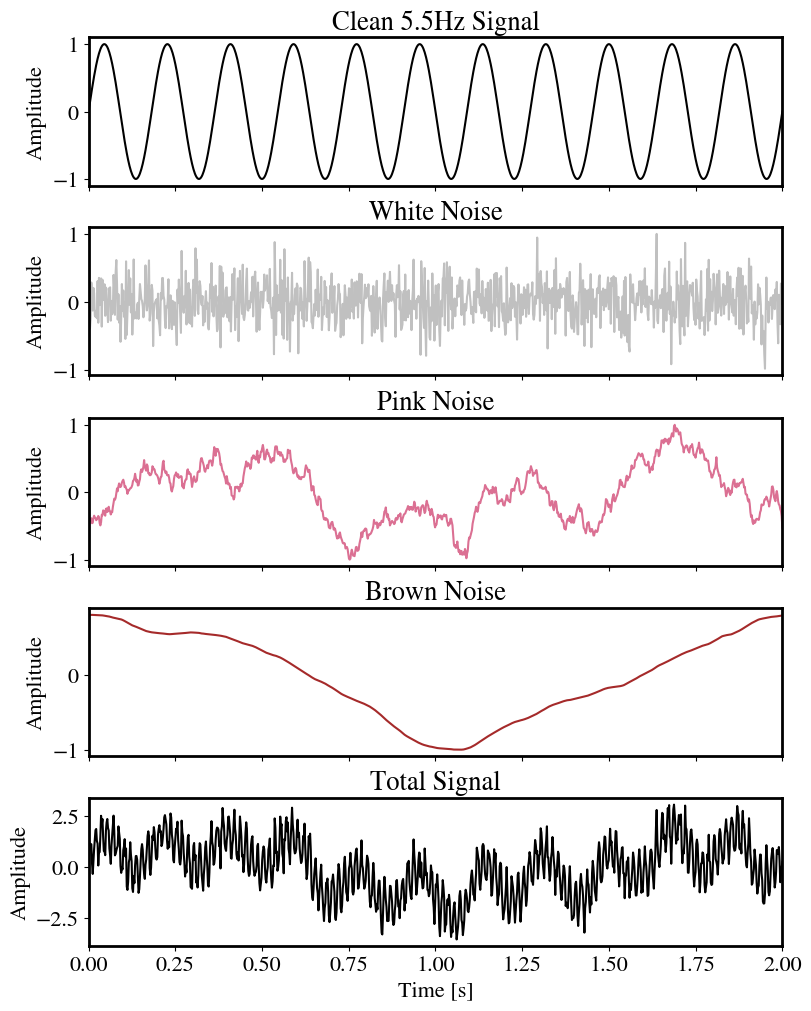

In [6]:
fig, axes = plt.subplots(5, 1, figsize=(8, 10), sharex=True, constrained_layout=True)

axes[0].plot(times, clean_signal, 'k')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim(times[0].value, times[-1].value)
axes[0].set_title('Clean 5.5Hz Signal')

colors = ['silver', 'palevioletred', 'brown']
for i, name in enumerate(noise.keys()):
    axes[i+1].plot(times, noise[name], color=colors[i])
    axes[i+1].set_xlim(times[0].value, times[-1].value)
    axes[i+1].set_ylabel('Amplitude')
    axes[i+1].set_title(f'{name} Noise')

axes[-1].plot(times, clean_signal + dirty_signal, 'k')
axes[-1].set_xlabel(f'Time [{times.unit}]')
axes[-1].set_ylabel('Amplitude')
axes[-1].set_title('Total Signal')

plt.show()

In [7]:
NSIG = 3
column_labels = ['Signal', '1σ', '3σ', 'N > 3σ']

data = [
    ['Clean 5.5Hz', f'{np.std(clean_signal):.2f}', f'{NSIG * np.std(clean_signal):.2f}', f'{len(np.argwhere(np.abs(clean_signal)>NSIG*np.std(clean_signal))):.0f}'],
    ['White Noise', f'{np.std(noise['White']):.2f}', f'{NSIG * np.std(noise['White']):.2f}', f'{len(np.argwhere(np.abs(noise['White'])>NSIG*np.std(noise['White']))):.0f}'],
    ['Pink Noise', f'{np.std(noise['Pink']):.2f}', f'{NSIG * np.std(noise['Pink']):.2f}', f'{len(np.argwhere(np.abs(noise['Pink'])>NSIG*np.std(noise['Pink']))):.0f}'],
    ['Brown Noise', f'{np.std(noise['Brown']):.2f}', f'{NSIG * np.std(noise['Brown']):.2f}', f'{len(np.argwhere(np.abs(noise['Brown'])>NSIG*np.std(noise['Brown']))):.0f}'],
]

df = pd.DataFrame(data, columns=column_labels)

df

,Signal,1σ,3σ,N > 3σ
0,Clean 5.5Hz,0.71,2.12,0
1,White Noise,0.29,0.86,6
2,Pink Noise,0.42,1.27,0
3,Brown Noise,0.56,1.69,0


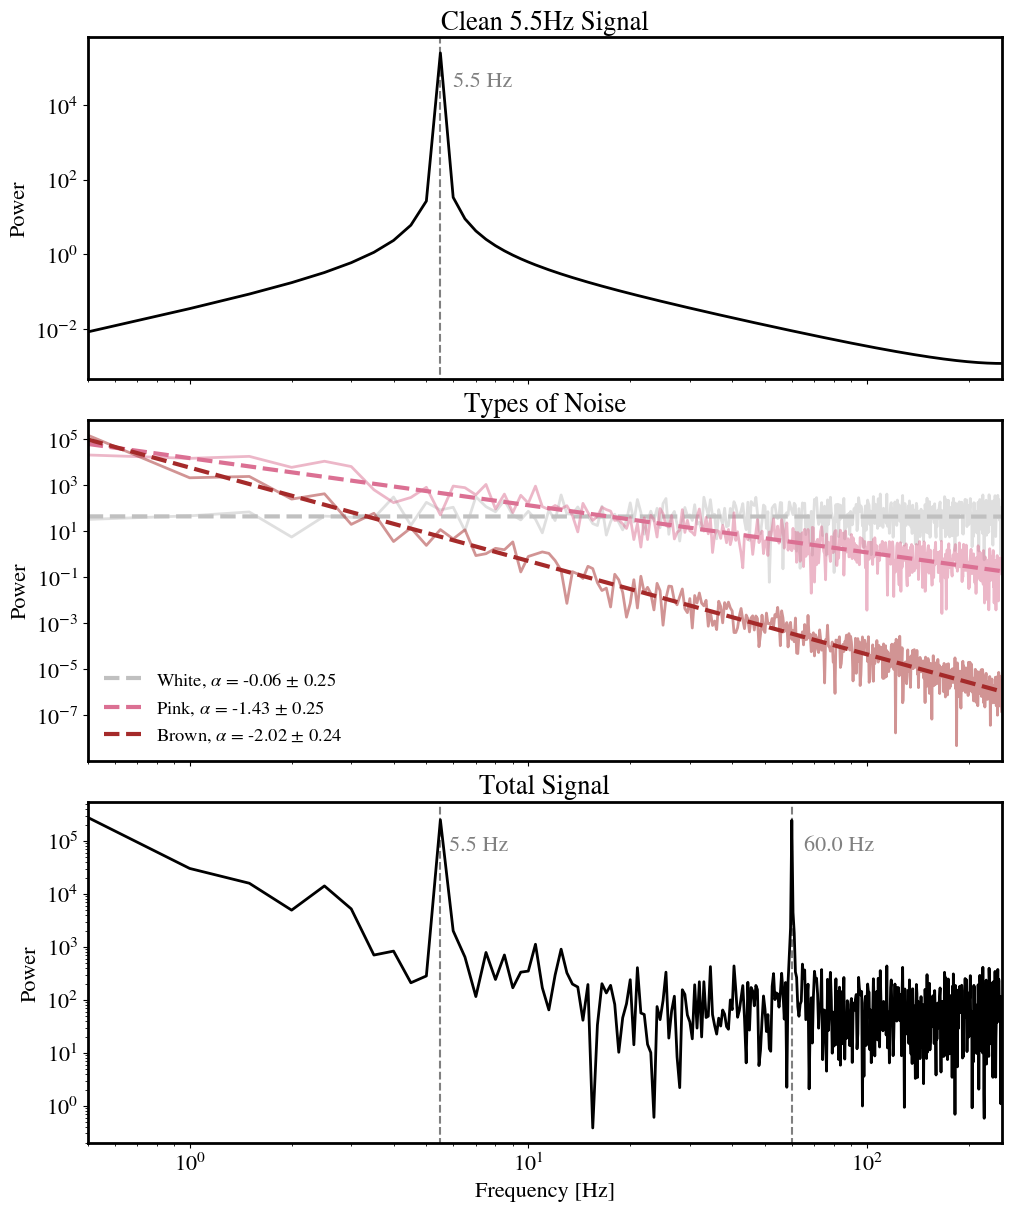

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True, constrained_layout=True)

axes[0].loglog(freqs[1:], power_spectrum(np.fft.rfft(clean_signal))[1:], 'k', lw=2)
axes[0].set_ylabel('Power')
axes[0].set_title('Clean 5.5Hz Signal')
# axes[0].set_ylim(1e-5, 1e8)
axes[0].vlines(CLEAN_FREQ.value, 1e-5, 1e8, color='grey', ls='dashed', zorder=-1)
axes[0].text(0.465, 0.90, f'{CLEAN_FREQ.to(u.Hz)}', horizontalalignment='right',
             verticalalignment='top', transform=axes[0].transAxes, fontsize=16, color='grey')

freq_range = np.linspace(np.log10(freqs[1].value), np.log10(freqs[-1].value), len(freqs))
colors = ['silver', 'palevioletred', 'brown']
for i, color, in enumerate(names):
    pwr = power_spectrum(np.fft.rfft(noise[color]))
    axes[1].loglog(freqs[1:], pwr[1:], color=colors[i], lw=2, alpha=0.5)
    fit = linear_fit(np.log10(freqs[1:].value), np.log10(pwr[1:]))
    axes[1].loglog(10**freq_range, 10**line(freq_range, *fit[0]), color=colors[i], ls='dashed', lw=3,
                   label=r'{0}, $\alpha$ = {1:.2f} $\pm$ {2:.2f}'.format(color, -np.sqrt(np.abs(fit[0][0])), np.sqrt(np.abs(fit[1][0]))))
    

axes[1].legend()
axes[1].set_ylabel('Power')
axes[1].set_title('Types of Noise')

axes[2].loglog(freqs[1:], power_spectrum(np.fft.rfft(clean_signal+dirty_signal))[1:], 'k', lw=2)
axes[2].vlines(DIRTY_FREQ.value, 1e-3, 1e9, color='grey', ls='dashed', zorder=-1)
axes[2].text(0.86, 0.90, f'{DIRTY_FREQ.to(u.Hz)}', horizontalalignment='right',
             verticalalignment='top', transform=axes[2].transAxes, fontsize=16, color='grey')
axes[2].vlines(CLEAN_FREQ.value, 1e-3, 1e9, color='grey', ls='dashed', zorder=-1)
axes[2].text(0.46, 0.90, f'{CLEAN_FREQ.to(u.Hz)}', horizontalalignment='right',
             verticalalignment='top', transform=axes[2].transAxes, fontsize=16, color='grey')
axes[2].set_xlabel(f'Frequency [{freqs.to(u.Hz).unit}]')
axes[2].set_ylabel('Power')
axes[2].set_title('Total Signal')

axes[2].set_xlim(freqs[1].value, freqs[-1].value)

plt.show()

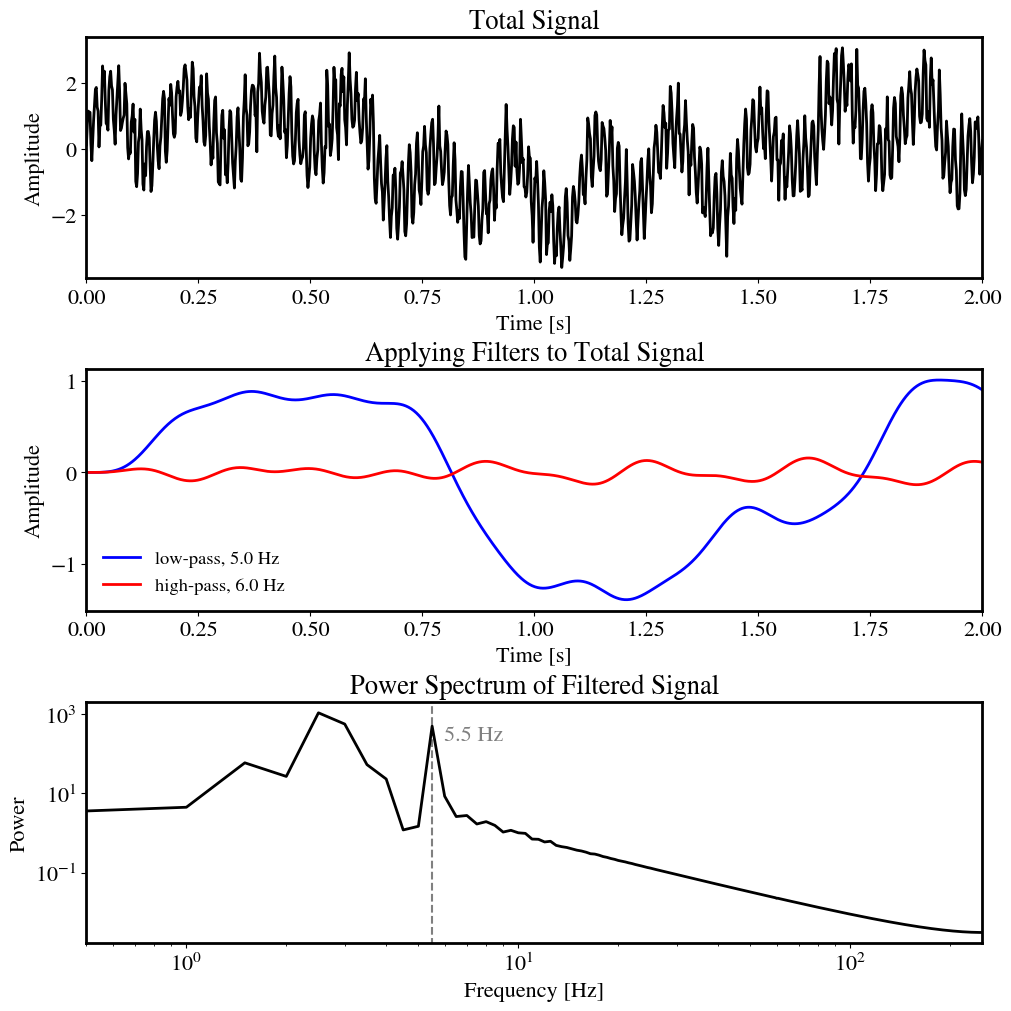

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(10,10), sharex=False, constrained_layout=True)
axes[0].plot(times, clean_signal+dirty_signal, 'k', lw=2)
axes[0].set_title('Total Signal')
axes[0].set_xlabel(f'Time [{times.unit}]')
axes[0].set_ylabel('Amplitude')
axes[0].set_xlim(times[0].value, times[-1].value)

LOW_PASS_FREQ = 5*u.Hz
HIGH_PASS_FREQ = 6*u.Hz
sos = signal.butter(4, LOW_PASS_FREQ, 'lp', fs=1000, output='sos')
lp_signal = signal.sosfilt(sos, clean_signal+dirty_signal)
axes[1].plot(times, lp_signal, label=f'low-pass, {LOW_PASS_FREQ}', color='blue', lw=2)
sos = signal.butter(4, HIGH_PASS_FREQ, 'hp', fs=1000, output='sos')
hp_signal = signal.sosfilt(sos, lp_signal)
axes[1].plot(times, hp_signal, label=f'high-pass, {HIGH_PASS_FREQ}', color='red', lw=2)
axes[1].set_title('Applying Filters to Total Signal')
axes[1].legend()
axes[1].set_xlabel(f'Time [{times.unit}]')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlim(times[0].value, times[-1].value)


filtered_signal = hp_signal
axes[2].loglog(freqs, power_spectrum(np.fft.rfft(filtered_signal)), color='k', lw=2)
axes[2].set_xlabel(f'Frequency [{freqs.to(u.Hz).unit}]')
axes[2].set_ylabel('Power')
axes[2].set_xlim(freqs[1].value, freqs[-1].value)
axes[2].vlines(CLEAN_FREQ.value, 1e-5, 1e8, color='grey', ls='dashed', zorder=-1)
axes[2].text(0.465, 0.90, f'{CLEAN_FREQ.to(u.Hz)}', horizontalalignment='right',
             verticalalignment='top', transform=axes[2].transAxes, fontsize=16, color='grey')
axes[2].set_title('Power Spectrum of Filtered Signal')
plt.show()

# Q2 - Working with images and what that negative k-correction actually means for sources. (30 pts)

In your last homework assignment, you whined about calculating the k-correction for some sub-mm galaxy.

So lets give you a more visual picture of what the negative k-correction actually does.
First, download and install DS9: http://ds9.si.edu/site/Home.html (or using conda)

Next, download the .fits files here: 
https://www.dropbox.com/scl/fo/pdcu1svt369dr5kshuq79/ALqZX0apyaqhxKO-qdjy-vg?rlkey=5y2hyqmlgzpjvn96whd1w348f&dl=0 

These are optical g,r,i DES images, an SPT 220GHz image, and an ALMA 870um image. Use Python to read in the .fits images.

In each case below, print your answer clearly (6 pts a piece) 
- Calculate the standard deviation of the SPT and ALMA maps. This is the noise.
- Now calculate the maximum signal-to-noise ratio in each map.
- Make a 3-color image from DES in DS9 (use trilogy: https://pypi.org/project/trilogy/)
- Overplot the SPT contours at 3,5,7,9 sigma (use scipy.stats)
- Overplot the ALMA contours at 5,10,15,20 sigma.

It should look something like this:
https://www.dropbox.com/scl/fi/bllp2l5293w4cb8eg5dyz/prob3_example.png


  


In [10]:
DATA_DIR = os.path.join(os.getcwd(), 'data/midterm_data/')

DES_FILES = glob.glob(os.path.join(DATA_DIR, 'DES*'))
ALMA_FILE = os.path.join(DATA_DIR, 'SPT0538-50_ALMA_870um.fits')
SPT_FILE = os.path.join(DATA_DIR, 'SPT0538-50_SPT_220GHz.fits')

images = {
    'des':{},
    'alma':{},
    'spt':{} 
}

for file in DES_FILES:
    hdul = fits.open(file)
    hdr, data = hdul[0].header, hdul[0].data
    f = hdr['FILTER']
    images['des'][f] = {}
    images['des'][f]['hdr'] = hdr
    images['des'][f]['data'] = data
    hdul.close()

hdul = fits.open(ALMA_FILE)
hdr, data = hdul[0].header, hdul[0].data
images['alma'] = {}
images['alma']['hdr'] = hdr
images['alma']['data'] = data[0][0]

hdul = fits.open(SPT_FILE)
hdr, data = hdul[0].header, hdul[0].data
images['spt'] = {}
images['spt']['hdr'] = hdr
images['spt']['data'] = data

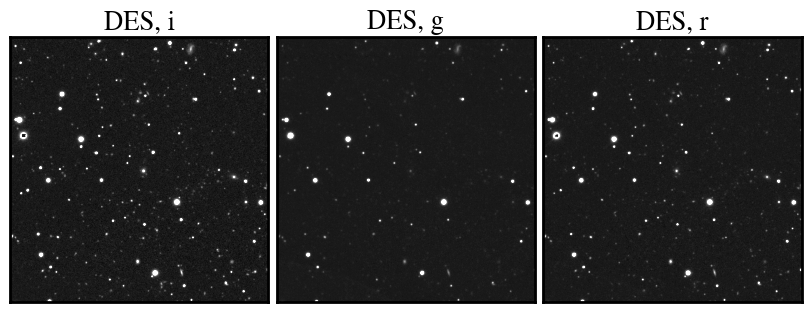

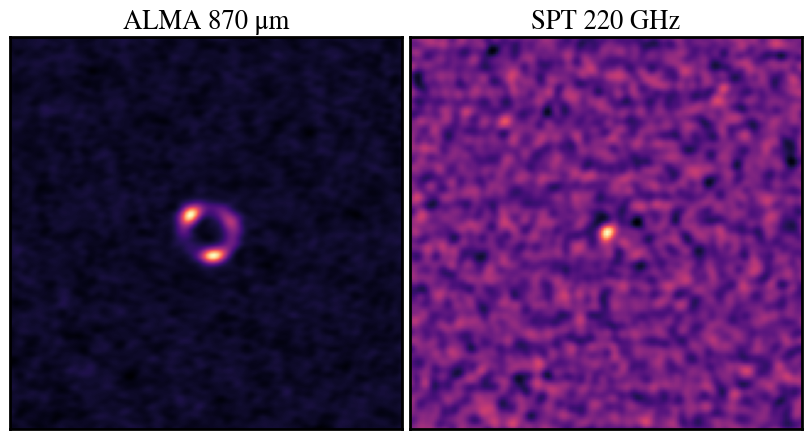

In [11]:
cmap = 'Greys_r'
fig, axes = plt.subplots(1, 3, figsize=(8,8), constrained_layout=True)
for i, filt in enumerate(images['des'].keys()):
    axes[i].imshow(images['des'][filt]['data'], cmap=cmap, origin='lower', vmin=-10, vmax=100)
    axes[i].set_title(f'DES, {filt}')
    axes[i].axes.xaxis.set_ticks([])
    axes[i].axes.yaxis.set_ticks([])
plt.show()

cmap = 'magma'
fig, axes = plt.subplots(1, 2, figsize=(8,8), constrained_layout=True)
axes[0].imshow(images['alma']['data'], cmap=cmap, origin='lower')
axes[0].axes.xaxis.set_ticks([])
axes[0].axes.yaxis.set_ticks([])
axes[0].set_title('ALMA 870 μm')

axes[1].imshow(images['spt']['data'], cmap=cmap, origin='lower')
axes[1].axes.xaxis.set_ticks([])
axes[1].axes.yaxis.set_ticks([])
axes[1].set_title('SPT 220 GHz')
plt.show()


In [12]:
alma_mean, alma_median, alma_std = sigma_clipped_stats(images['alma']['data']) # Jy/Beam
alma_max = np.max(images['alma']['data'])
spt_mean, spt_median, spt_std = sigma_clipped_stats(images['spt']['data'])
spt_max = np.max(images['spt']['data'])

print(f'ALMA image noise: {alma_std:0.2e} Jy/beam')
print(f'Max ALMA S/N: {alma_max/alma_std:.2f}')
print(f'\nSPT image noise: {spt_std:0.2e} Jy/beam')
print(f'Max SPT S/N: {spt_max/spt_std:.2f}')

ALMA image noise: 4.59e-04 Jy/beam
Max ALMA S/N: 57.33

SPT image noise: 7.64e-05 Jy/beam
Max SPT S/N: 8.92


In [13]:
imagesRGB = {
    'G': [os.path.join(DATA_DIR, 'DESJ053816.9-503050.8_r.fits')],
    'B': [os.path.join(DATA_DIR, 'DESJ053816.9-503050.8_g.fits')],
    'R': [os.path.join(DATA_DIR, 'DESJ053816.9-503050.8_i.fits')]
}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}

trilogy.Trilogy(infile = None, 
                samplesize = 20000, 
                stampsize = 20000, 
                maxstampsize = 20000,
                deletetests = 1, 
                deletefilters = 1, 
                testfirst = 0, 
                showwith = "PIL",
                mode = 'RGB', 
                imagesorder = 'RGB', 
                imagesRGB = imagesRGB, 
                noiselums = noiselums, 
                images = None,
                outname = 'des_rgb_image', 
                satpercent = 0.0009, 
                noiselum = 0.5, 
                noisesig = 70,
                noisesig0 = 10, 
                correctbias = 0, 
                colorsatfac = 1, 
                combine = 'sum', 
                show = True).run()

From input file None :
From input parameters:
samplesize = 20000
stampsize = 20000
maxstampsize = 20000
deletetests = 1
deletefilters = 1
testfirst = 0
showwith = PIL
mode = RGB
imagesRGB = {'G': ['/Users/darbymccauley/coursework/ast503_2024_Fall/homework/darby_mccauley/data/midterm_data/DESJ053816.9-503050.8_r.fits'], 'B': ['/Users/darbymccauley/coursework/ast503_2024_Fall/homework/darby_mccauley/data/midterm_data/DESJ053816.9-503050.8_g.fits'], 'R': ['/Users/darbymccauley/coursework/ast503_2024_Fall/homework/darby_mccauley/data/midterm_data/DESJ053816.9-503050.8_i.fits']}
noiselums = {'R': 0.5, 'G': 0.5, 'B': 0.5}
outname = des_rgb_image
satpercent = 0.0009
noiselum = 0.5
noisesig = 70
noisesig0 = 10
correctbias = 0
colorsatfac = 1
combine = sum
show = True
invert = False
Default:
indir =  (default)
outdir =  (default)
thumbnail = None (default)
sampledx = 0 (default)
sampledy = 0 (default)
showstamps = 0 (default)
scaling = None (default)
legend = 0 (default)
noise = None (default)


In [15]:
des_wcs = WCS(images['des']['g']['hdr'])
alma_wcs = WCS(images['alma']['hdr'], naxis=2)
spt_wcs = WCS(images['spt']['hdr'])

In [16]:
spt_sigs = np.arange(3, 9+2, 2)
alma_sigs = np.arange(5, 20+5, 5)

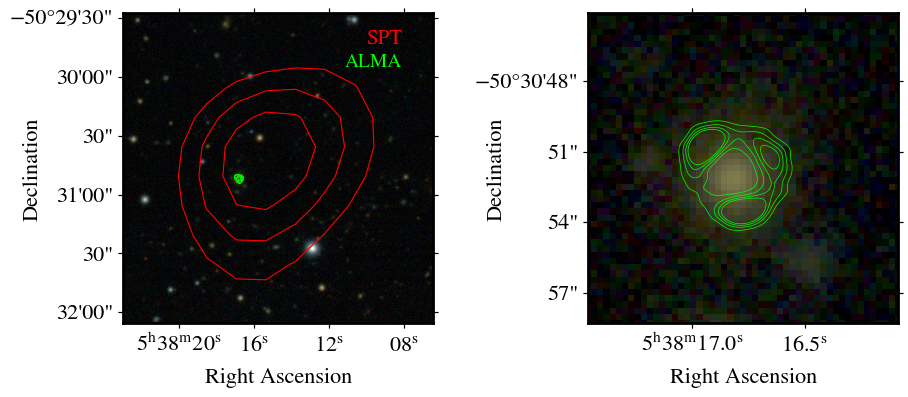

In [17]:
des_img = Image.open('des_rgb_image.png')

fig = plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.5) 

ax0 = plt.subplot(1, 2, 1, projection=des_wcs)
ax0.imshow(des_img, origin='lower')
ax0.contour(images['spt']['data'], transform=ax0.get_transform(spt_wcs), levels=spt_std*spt_sigs, origin='lower', colors='red', linewidths=0.8)
ax0.text(0.90, 0.95, f'SPT', horizontalalignment='right',
        verticalalignment='top', transform=ax0.transAxes, fontsize=15, color='red')
ax0.contour(images['alma']['data'], transform=ax0.get_transform(alma_wcs), levels=alma_std*alma_sigs, origin='lower', colors='lime', linewidths=0.5)
ax0.text(0.90, 0.87, f'ALMA', horizontalalignment='right',
        verticalalignment='top', transform=ax0.transAxes, fontsize=14, color='lime')
ax0.set_xlim(350, 950)
ax0.set_ylim(285, 885)
ax0.set_xlabel('Right Ascension')
ax0.set_ylabel('Declination', labelpad=-1)

ax1 = plt.subplot(1, 2, 2, projection=des_wcs)
ax1.imshow(des_img, origin='lower')
ax1.contour(images['alma']['data'], transform=ax1.get_transform(alma_wcs), levels=alma_std*alma_sigs, origin='lower', colors='lime', linewidths=0.5)
ax1.set_xlim(550, 600)
ax1.set_ylim(540, 590)

ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination', labelpad=-1)

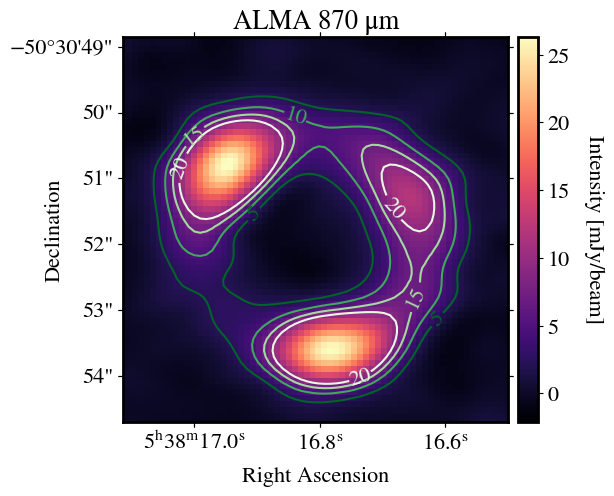

In [18]:
cmap = 'magma'

fig, ax = plt.subplots(1,1 , subplot_kw={'projection': alma_wcs})
im = ax.imshow(images['alma']['data'] * 1e3, cmap=cmap, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1, axes_class=maxes.Axes)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Intensity [mJy/beam]', rotation=270, labelpad=25)

colors = plt.cm.Greens_r(np.linspace(0.1, 0.9, len(alma_sigs)))
cplot = ax.contour(images['alma']['data'], levels=alma_std*alma_sigs, colors=colors)

ax.set_ylim(120, 185)
ax.set_xlim(120, 185)
ax.set_title('ALMA 870 μm')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination', labelpad=-2)

fmt = {}
strs = ['5', '10', '15', '20'] 
for l, s in zip(cplot.levels, strs): 
    fmt[l] = s 
ax.clabel(cplot, cplot.levels, inline=True, fmt=fmt) 
plt.show()

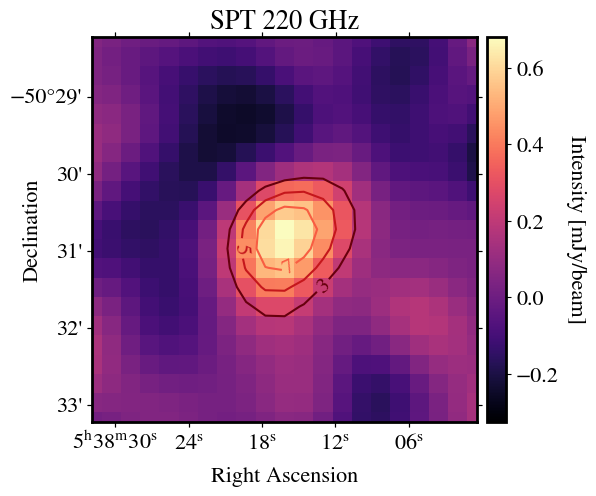

In [19]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': spt_wcs})
im = ax.imshow(images['spt']['data'] * 1e3, cmap=cmap, origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1, axes_class=maxes.Axes)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Intensity [mJy/beam]', rotation=270, labelpad=20)

colors = plt.cm.Reds_r(np.linspace(0.0, 0.7, len(spt_sigs)))
cplot = ax.contour(images['spt']['data'], levels=spt_std*spt_sigs, colors=colors)

ax.set_ylim(70, 90)
ax.set_xlim(70, 90)
ax.set_title('SPT 220 GHz')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination', labelpad=-1)

fmt = {}
strs = ['3', '5', '7', '9'] 
for l, s in zip(cplot.levels, strs): 
    fmt[l] = s 
ax.clabel(cplot, cplot.levels, inline=True, fmt=fmt) 
plt.show()

# Q3 - Coordinates, time conversions (30 pts) 

The star Vega (which you all know and love by now) has RA = 18h 36m 56s and Declination +38 deg 47' 01".

- Convert these coordinates
  a) decimal degrees
  b) into galactic coordinates

The University of Illinois observatory is at latitutde 40.112 degrees, while our longitude is -88.221 degrees.

- Use the expressions in the class slides to write a function that accepts arbitrary coordinates in RA and Dec and calculates the rise and set time of this source over the course of 2024.
  
- Plot the rise and set and set time of Vega for 2024
  

In [20]:
# (ra, dec) of Vega
VEGA_RA, VEGA_DEC = '18h36m56s', '+38d47m01s'

# University of Illinois Observatory Coordinates
LAT = 40.112 * u.degree
LON = -88.221 * u.degree 

# NGC (ra, dec) (J2000)
RA_NGP = 192.85948 * u.degree
DEC_NGP = 27.12825 * u.degree

L_NCP = 122.93192 * u.degree # galactic longitude of NCP

# Dates in 2024
YEAR = 2024
MONTHS = np.arange(1, 13, 1)
ndays = [calendar.monthrange(YEAR, month)[1] for month in MONTHS]
days = [np.arange(1, n+1, 1) for n in ndays]

# Format dates as YYYY-MM-DD
dates = []
for m, month in enumerate(MONTHS):
    for day in days[m]:
        date = f'{YEAR}-{month}-{day}'
        dates.append(date)
dates = np.array(dates)

# Getting the dates affected by daylight savings
DST_START = np.argwhere(dates == '2024-3-10')[0][0]
DST_END = np.argwhere(dates == '2024-11-3')[0][0]
dst_dates = dates[DST_START:DST_END]

In [21]:
deg_per_hour = (360 * u.deg) / (24 * u.hr)
JD2000 = 2451545

def ra_to_hr(ra):
    """ 
    Convert an hour angle in (str)|[hms] format to hours.
    """
    h, r = ra.split('h')
    m, r = r.split('m')
    s, _ = r.split('s')
    return float(h)*u.hr + (float(m)*u.min).to(u.hr) + (float(s)*u.s).to(u.hr)

def radec_to_deg(ra, dec):
    """
    Convert ra, dec into decimal form.

    Inputs:
        - ra (str)|[hms]: right ascension
        - dec (str)|[dms]: declination
    Returns:
        - ra (float)|[deg]
        - dec (float)|[deg]
    """
    # convert RA
    h, r = ra.split('h')
    m, r = r.split('m')
    s, _ = r.split('s')
    degh = float(h)*u.hr * deg_per_hour
    degm = (float(m)*u.min).to(u.hr) * deg_per_hour
    degs = (float(s)*u.s).to(u.hr) * deg_per_hour
    degra = degh + degm + degs
    # convert DEC
    d, r = dec.split('d')
    m, r = r.split('m')
    s, _ = r.split('s')
    degd = float(d)*u.degree
    degm = (float(m)*u.arcmin).to(u.degree) 
    degs = (float(s)*u.arcsec).to(u.degree)
    degdec = degd + degm + degs
    
    return degra, degdec

def eq_to_gal(ra, dec):
    """
    Convert equitorial coordinates into galactic coordinates.

    Inputs:
        - ra (str)|[hms]: right ascension
        - dec (str)|[dms]: declination
    Returns:
        - l (float)|[deg]: galactic longitude
        - b (float)|[deg]: galactic latitude
    """
    degra, degdec = radec_to_deg(ra, dec)
    b = np.arcsin( np.cos(degdec) * np.cos(DEC_NGP) * np.cos(degra - RA_NGP) + np.sin(degdec) * np.sin(DEC_NGP) ).to(u.degree)
    l = ( L_NCP - np.arcsin( (np.cos(degdec) * np.sin(degra - RA_NGP)) / np.cos(b)) ).to(u.degree)
    return l, b 

def julian_date(date):
    """
    Compute the Julian Date for a given date.
    
    Inputs:
        - date (str)|[YYYY-M-DD]: date 
    Returns:
        - Julian date (float)
    """
    year, month, day = date.split('-')
    a = (1461 * (int(year) + 4800 + (int(month) - 14) // 12)) // 4
    b = (367 * (int(month) - 2 - 12 * ((int(month) - 14) // 12))) // 12
    c = (3 * ((int(year) + 4900 + (int(month) - 14) // 12) // 100)) // 4
    d =  int(day) - 32075
    jdn = a + b -  c + d
    return jdn

def rise_time(ra, dec, lat, lon, date):
    """
    Compute the time a source will rise for an observer at a particular location on a particular day.
    
    Inputs:
        - ra (str)|[hms]: right ascension of source
        - dec (str)|[dms]: declination of source
        - lat (float)|(degrees): observer latitude
        - lon (float)|(degrees): observer longitude
        - date (str)|[YYYY-M-DD]: date of observation
    Returns:
        - rise time (float)|[hrs]: hours past midnight the source will rise (local time)

    """
    degra, degdec = radec_to_deg(ra, dec)
    ha_rise = np.arccos(-np.tan(np.deg2rad(degdec)) * np.tan(np.deg2rad(lat))).to(u.degree)
    HA_rise = ha_rise / deg_per_hour
    lst_rise = 24*u.hr + degra/deg_per_hour - HA_rise % (24*u.hr)
    gst_rise = (lst_rise - lon/deg_per_hour) % (24*u.hr)
    gmst = compute_gmst(date)
    ut_rise = (gst_rise - gmst) % (24*u.hr)
    if date in dst_dates:
        DST = -5*u.hr
    else: DST = -6*u.hr
    local_time = (ut_rise + DST) % (24*u.hr)
    return local_time

def set_time(ra, dec, lat, lon, date):
    """
    Compute the time a source will set for an observer at a particular location on a particular day.
    
    Inputs:
        - ra (str)|[hms]: right ascension of source
        - dec (str)|[dms]: declination of source
        - lat (float)|(degrees): observer latitude
        - lon (float)|(degrees): observer longitude
        - date (str)|[YYYY-M-DD]: date of observation
    Returns:
        - set time (float)|[hrs]: hours past midnight the source will set (local time)

    """
    degra, degdec = radec_to_deg(ra, dec)
    ha_set = np.arccos(-np.tan(np.deg2rad(degdec)) * np.tan(np.deg2rad(lat))).to(u.degree)
    HA_set = ha_set / deg_per_hour
    lst_set = degra/deg_per_hour + HA_set % (24*u.hr)
    gst_set = (lst_set - lon/deg_per_hour) % (24*u.hr)
    gmst = compute_gmst(date)
    ut_set = (gst_set - gmst) % (24*u.hr)
    if date in dst_dates:
        DST = -5*u.hr
    else: DST = -6*u.hr
    local_time = (ut_set + DST) % (24*u.hr)
    return local_time

def compute_gmst(date):
    """
    Compute the Greenwich Mean Sidereal Time (GMST) of a given day.
    
    Inputs:
        - date (str)|[YYYY-M-DD]: date 
    Returns:
        - gmst (float)|[hrs]: Greenwich Mean Sidereal Time
    """
    jd = julian_date(date)
    const = '6h41m50.54841s'
    T = (jd - JD2000) / 36525
    gmst = (ra_to_hr(const).to(u.s) + (8640184.812866*T + 0.093104*T**2 - 6.2e-6*T**3)*u.s).to(u.hr)
    gmst = gmst % (24*u.hr)
    return gmst

In [22]:
VEGA_RA_DEG, VEGA_DEC_DEG = radec_to_deg(VEGA_RA, VEGA_DEC)
print(f'Vega equitorial coords (ra, dec): ({VEGA_RA_DEG:0.3f}, {VEGA_DEC_DEG:0.3f})')

VEGA_L, VEGA_B = eq_to_gal(VEGA_RA, VEGA_DEC)
print(f'Vega galactic coords (l, b): ({VEGA_L:0.3f}, {VEGA_B:0.3f})')

Vega equitorial coords (ra, dec): (279.233 deg, 38.784 deg)
Vega galactic coords (l, b): (67.448 deg, 19.238 deg)


In [23]:
rise_times = np.array([rise_time(VEGA_RA, VEGA_DEC, LAT, LON, date).value for date in dates])
set_times = np.array([set_time(VEGA_RA, VEGA_DEC, LAT, LON, date).value for date in dates])

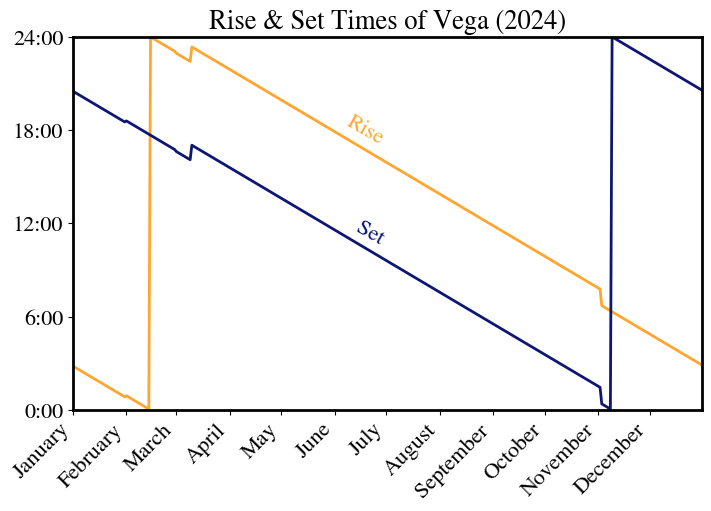

In [24]:
firsts = np.array([np.argwhere(dates == f'2024-{m}-1')[0][0] for m in MONTHS])
fig, ax = plt.subplots(1, 1, constrained_layout=True)
ax.plot(dates, rise_times, color='#FFA630', label='Rise', lw=2)
ax.text(0.5, 0.8, 'Rise', horizontalalignment='right', verticalalignment='top', 
        transform=ax.transAxes, fontsize=16, color='#FFA630', rotation=-30)

ax.plot(dates, set_times, color='#0D1773', label='Set', lw=2)
ax.text(0.5, 0.515, 'Set', horizontalalignment='right', verticalalignment='top', 
        transform=ax.transAxes, fontsize=16, color='#0D1773', rotation=-30)

_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
ax.set_xticks(dates[firsts], _months, rotation=45, ha='right')
_times = ['0:00', '6:00', '12:00', '18:00', '24:00']
ax.set_yticks(np.arange(0, 24+6, 6), _times)
ax.set_xlim(dates[0], dates[-1])
ax.set_ylim(0, 24)
ax.set_title('Rise & Set Times of Vega (2024)')

plt.show()

### Divide and conquer, so you encounter issues in parallel and can explain things to each other, rather than working in series. 

# Due Oct 22 at Noon!